### Board Detection

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
import sys
sys.path.append('../src')
import util
import findchess

# warning: will actually flip if only one channel i.e. grayscale
rgb = lambda img : np.flip(img, axis=-1)  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- Read image from file

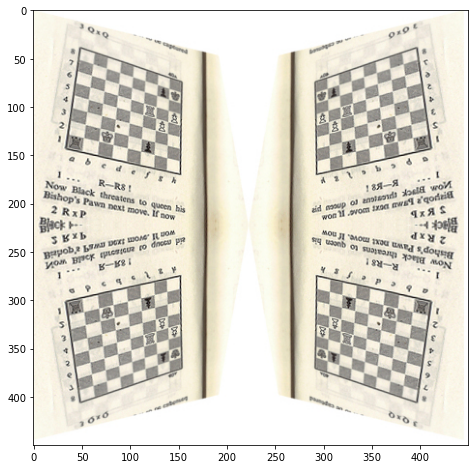

In [4]:
img = cv2.imread('orig.png')
plt.imshow(rgb(img))

- Convert image to grayscale

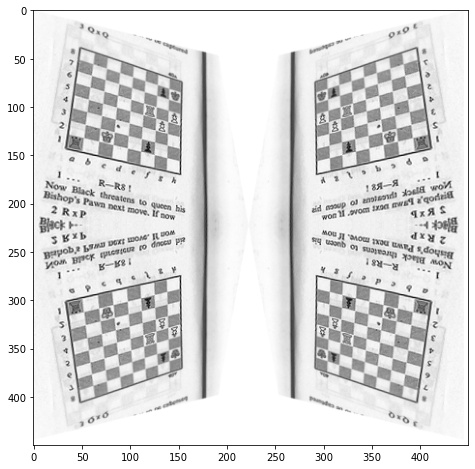

In [5]:
im_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(im_gray, 'gray')

- Convert to black and white taking into account average image brightness.

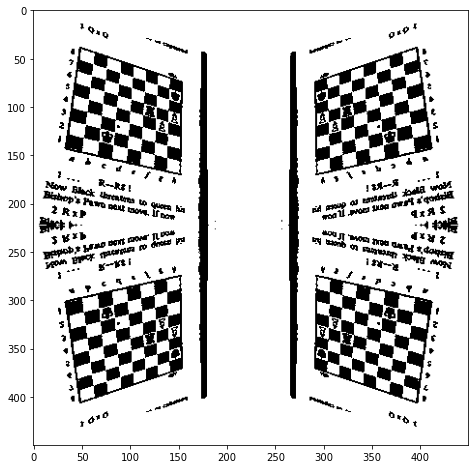

In [6]:
(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(im_bw, 'gray')

- Find contours using cv2.findContours

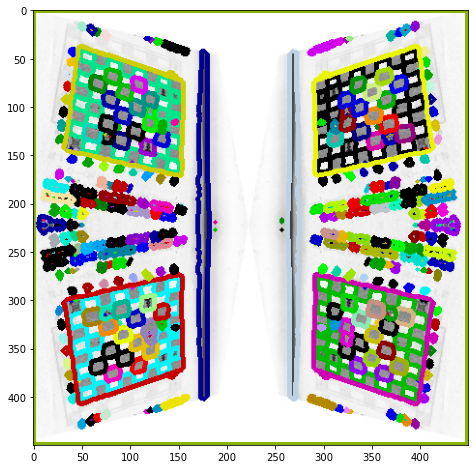

In [7]:
contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
im_contour = cv2.cvtColor(im_gray, cv2.COLOR_GRAY2BGR)
for c in contours:
    c = np.squeeze(c, 1)
    util.drawContour(im_contour, c, util.randomColor())
    
plt.imshow(rgb(im_contour))

- Filter irrelevant contours:
    - Area either too small or too large
    - Height-to-width ratio "not close to 1"

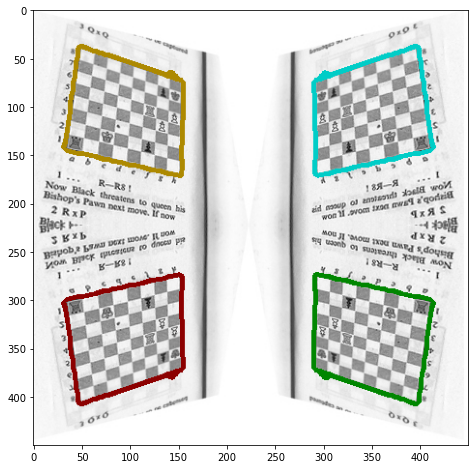

In [8]:
contours = findchess.Contours(img)
filtered = contours.filter()
im_contour = cv2.cvtColor(im_gray, cv2.COLOR_GRAY2BGR)
for contour in filtered:
    contour = np.squeeze(contour, 1)
    util.drawContour(im_contour, contour, util.randomColor())

plt.imshow(rgb(im_contour))

### Board Extraction and Perspective Correction

- Draw each contour in an individual black buffer.

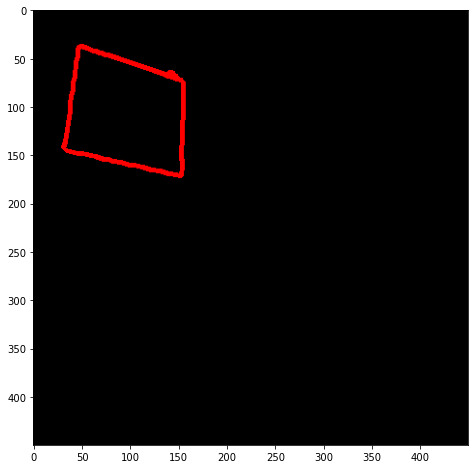

In [9]:
height, width, _ = img.shape
blank = cv2.cvtColor(np.zeros((height, width), np.uint8), cv2.COLOR_GRAY2BGR)
blank_canvas = blank.copy()
contour1 = np.squeeze(filtered[-1], 1)
red = (0, 0, 255)
util.drawContour(blank_canvas, contour1 , red)
plt.imshow(rgb(blank_canvas))

- Find lines by using the standard Hough transform. This is done, iteratively, progressively decreasing the accumulator threshold parameter until there exactly 2 horizontal lines and 2 vertical lines (with some degree of freedom).
    - Lines that are too close to each other are ignored

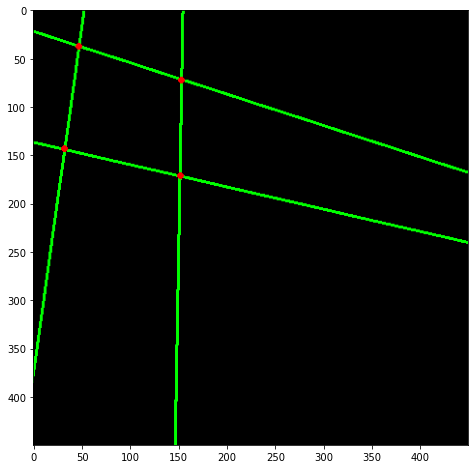

In [10]:
# Based on Perspective.get_perspective()

houghThreshold = 150
hough_threshold_step = 20

canvas_with_contour = cv2.cvtColor(blank_canvas, cv2.COLOR_BGR2GRAY)

grid= None
for i in range(houghThreshold//hough_threshold_step):
    one_pixel = 1
    one_degree = np.pi/180
    threshold = houghThreshold - i*hough_threshold_step
    hough_lines = cv2.HoughLines(canvas_with_contour, one_pixel, one_degree, threshold)
    if hough_lines is None:
        continue
        
    lines = [findchess.Line(line[0], line[1]) for line in hough_lines.squeeze(axis=1)]
    horizontal, vertical = findchess.partition_lines(lines)
    vertical = findchess.filter_close_lines(vertical, horizontal=False)
    horizontal = findchess.filter_close_lines(horizontal, horizontal=True)

    if len(vertical) == 2 and len(horizontal) == 2:
        grid = (vertical, horizontal)
        break

if grid:
    if vertical[0].get_center()[0] > vertical[1].get_center()[0]:
        v2, v1 = vertical
    else:
        v1, v2 = vertical

    if horizontal[0].get_center()[1] > horizontal[1].get_center()[1]:
        h2, h1 = horizontal
    else:
        h1, h2 = horizontal

        
    canvas_for_grid = blank.copy()
    green = (0, 255, 0)
    thickness = 2
    for grid_line in (v1, v2, h1, h2):
        grid_line.draw(canvas_for_grid, green, thickness)

    perspective = (h1.intersect(v1), h1.intersect(v2), h2.intersect(v2), h2.intersect(v1))
    for p in perspective:
        util.drawPoint(canvas_for_grid, p, red, radius=2, thickness=2)
        
    plt.imshow(rgb(canvas_for_grid))
else:
    print('Algorithm did not find a grid for the contour.')

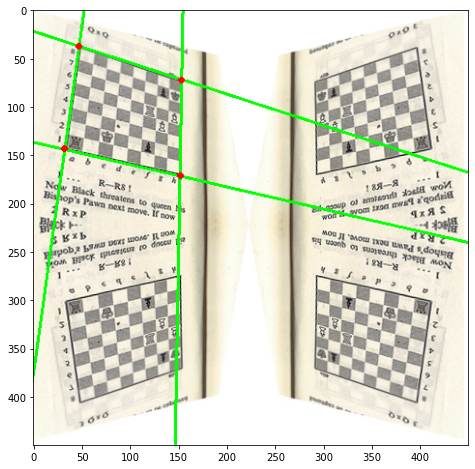

In [11]:
imgcopy = img.copy()
for grid_line in (v1, v2, h1, h2):
    grid_line.draw(imgcopy, green, thickness)

for p in perspective:
    util.drawPoint(imgcopy, p, red, radius=2, thickness=2)

plt.imshow(rgb(imgcopy))

- Calculate the perspective correction transformation using the 4 points of intersection.
- Apply the transformation to a copy of the original image and crop it to size.

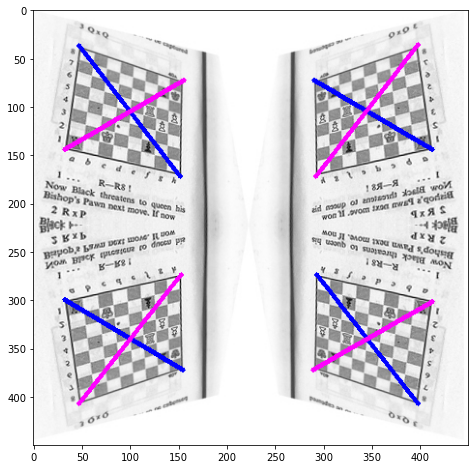

In [14]:
# Based on extract_boards()

im_pers = cv2.cvtColor(im_gray, cv2.COLOR_GRAY2BGR)
board_size = 200  # pixels
boards = []
for contour in filtered:
    contour = np.squeeze(contour, 1)
    
    perspective = findchess.Perspective.get_perspective(img, contour)
    if perspective is not None:
        b = perspective.correction(img, board_size, board_size)
        boards.append(b)
        util.drawPerspective(im_pers, perspective.perspective)

plt.imshow(rgb(im_pers))        

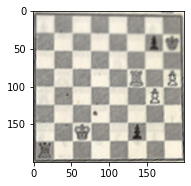

In [15]:
if boards:
    px = 1/plt.rcParams['figure.dpi']
    plt.figure(figsize=(board_size*px, board_size*px))
    plt.imshow(rgb(boards[-1]))